72
Len rads = 72
 KDEs = [0.10834929 0.26350449]


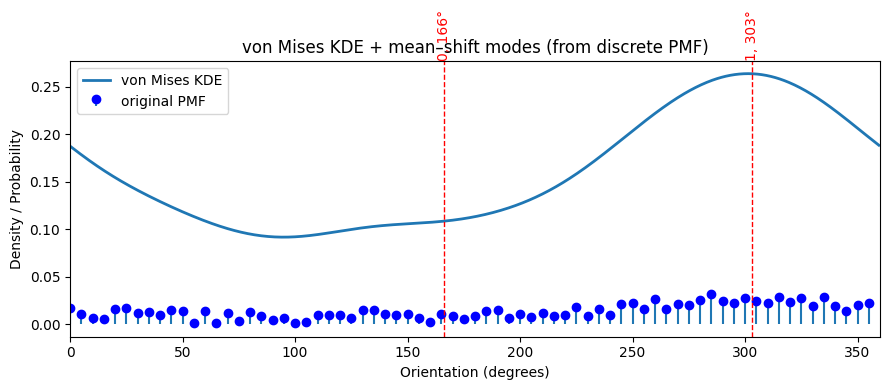

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import i0


# ------------------------------------------------------------------
#  utilities
# ------------------------------------------------------------------
def wrap(a):
    """Map angle to [0, 2π)."""
    return np.mod(a, 2 * np.pi)


def vonmises_kde_weighted(grid, angles, probs, kappa):
    """
    Weighted von-Mises KDE on the circle.

    grid   : (M,) evaluation points [rad]
    angles : (N,) discrete support angles [rad]
    probs  : (N,) probabilities,  Σp_i = 1
    kappa  : concentration
    """
    # grid = np.atleast_1d(grid)
    kern = np.exp(kappa * np.cos(grid[:, None] - angles))   # (M, N)
    return (probs * kern).sum(axis=1) / (2 * np.pi * i0(kappa))


def circular_mean_shift_weighted(angles, probs, kappa,
                                 max_iter=100, tol=1e-6):
    """
    Mean–shift on the circle with *weighted* von-Mises kernel.

    angles : (N,) support points [rad]
    probs  : (N,) probabilities,  Σp_i = 1
    """
    theta = wrap(angles.copy())

    for _ in range(max_iter):
        theta_old = theta.copy()

        # θ_i - θ_j  →  shape (N, N)
        diff = theta[:, None] - theta
        # kernel weights ∘ probabilities
        w = probs * np.exp(kappa * np.cos(diff))            # (N, N)

        # circular weighted mean for each column j
        sin_term = (w * np.sin(theta)).sum(axis=1)
        cos_term = (w * np.cos(theta)).sum(axis=1)
        theta = wrap(np.arctan2(sin_term, cos_term))

        dtheta = np.abs(np.angle(np.exp(1j * (theta - theta_old))))
        if dtheta.max() < tol:
            break
    return theta


# ------------------------------------------------------------------
#  example — replace these two arrays with *your* data
# ------------------------------------------------------------------
# angles at 5° resolution:
angles_deg = np.arange(0, 360, 5)
angles_rad = np.deg2rad(angles_deg)

# toy PMF: a broad bump around 300° plus some noise
rng = np.random.default_rng(0)
probs = np.exp(2 * np.cos(np.deg2rad(angles_deg - 300)))
probs += 5 * rng.random(len(angles_deg))          # tiny background noise
probs /= probs.sum()                                 # normalise to Σp_i = 1
print(len(probs))

# choose kernel width (κ)
kappa = 4

# ------------------------------------------------------------------
#  run mean–shift + KDE
# ------------------------------------------------------------------
modes = circular_mean_shift_weighted(angles_rad, probs, kappa)
unique_modes = np.unique(np.round(np.rad2deg(modes), 0))    # 1° tolerance

grid = np.linspace(0, 2 * np.pi, 720, endpoint=False)       # 0.5° grid
print(f"Len rads = {len(angles_rad)}")
pdf = vonmises_kde_weighted(grid, angles_rad, probs, kappa)

# ------------------------------------------------------------------
#  Cartesian plot
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 4))

ax.plot(np.rad2deg(grid), pdf, label='von Mises KDE', lw=2)

# show the discrete PMF as dots
ax.stem(angles_deg, probs, markerfmt='bo', basefmt=" ",
        label='original PMF')

# mark the modes
print(f' KDEs = {vonmises_kde_weighted(np.deg2rad(unique_modes), angles_rad, probs, kappa)}')
for i,m in enumerate(unique_modes):
    ax.axvline(m, ls='--', color='red', lw=1)
    ax.text(m, pdf.max()*1.05, f'{i}, {m:.0f}°', rotation=90,
            ha='center', va='bottom', color='red')

ax.set_xlim(0, 360)
ax.set_xlabel('Orientation (degrees)')
ax.set_ylabel('Density / Probability')
ax.set_title('von Mises KDE + mean–shift modes (from discrete PMF)')
ax.legend()
plt.tight_layout()
plt.show()